## Acknowledgements

- https://www.kaggle.com/piantic/starter-optiver-quick-eda-automl-wip
- https://www.kaggle.com/konradb/we-need-to-go-deeper-and-validate
- https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data


## Setting up

In [2]:
# Imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
import random

from pylab import rcParams
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.special import boxcox1p
from pprint import pprint

import cufflinks as cf
import plotly.offline

# Add base dir path to sys.path so that I can do local exports
sys.path.append("../..")
import utils

In [3]:
# Global settings

# Initialise logger
LOGGER = utils.get_logger("house-prices")

# To ignore warnings
warnings.filterwarnings("ignore")

#Limiting float output to 4 decimal points
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# Default figure size in inches
rcParams['figure.figsize'] = 12,6

# Print on each line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Turn ON offline mode for plotly cufflinks iplots
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [4]:
# Configuration
class Config:
    data_dir = "./data/"
    seed_value = 34
    nfolds = 10
    learning_rate = 0.05
    

In [5]:
# Seed All
def seed_all(seed_value=Config.seed_value):
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    
seed_all()

## Helpers

In [6]:
def log_return(stock_prices_series):
    return np.log(stock_prices_series).diff()

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def fill_wap(stock_df):
    l1_sum = stock_df["bid_price1"] * stock_df["ask_size1"] + \
             stock_df["ask_price1"] * stock_df["bid_size1"]
    l1_sizes = stock_df["ask_size1"] + stock_df["bid_size1"]
    
    l1_l2_sum = l1_sum + stock_df["bid_price2"] * stock_df["ask_size2"] + \
                         stock_df["ask_price2"] * stock_df["bid_size2"]
    l1_l2_sizes = l1_sizes + stock_df["ask_size2"] + stock_df["bid_size2"]
                                      
    # L1 wap
    stock_df["wap"] = l1_sum / l1_sizes
    
    # L1 and L2 combined wap
    stock_df["wap_l2"] = l1_l2_sum / l1_l2_sizes
    return stock_df
                                    

## Load data and preprocess

#### Book and Trade example

In [7]:
book = pd.read_parquet(f"{Config.data_dir}/book_train.parquet/stock_id=6")
trades = pd.read_parquet(f"{Config.data_dir}/trade_train.parquet/stock_id=6")
book.set_index("time_id", inplace=True)
trades.set_index("time_id", inplace=True)

In [8]:
book.head()
trades.head()

,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
time_id,,,,,,,,,
5,0,1.0008,1.0025,1.0008,1.0025,100,110,1,1
5,1,1.0008,1.0025,1.0008,1.0025,4,110,1,1
5,5,1.0019,1.0029,1.0016,1.0030,12,1,34,1
5,6,1.0009,1.0029,1.0008,1.0030,100,1,70,1
5,7,1.0011,1.0029,1.0011,1.0030,100,1,70,1


,seconds_in_bucket,price,size,order_count
time_id,,,,
5,5,1.0025,116,8
5,12,1.0031,12,6
5,13,1.0032,5,3
5,15,1.0033,22,4
5,19,1.0029,2,1


In [9]:
def gather_book_stats(book_df):
    # L1 and L2 size spreads
    book_df["l1_size_spread"] = book_df["ask_size1"] - book_df["bid_size1"]
    book_df["l2_size_spread"] = book_df["ask_size2"] - book_df["bid_size2"]
    
    # L1 and L2 price spreads
    book_df["l1_price_spread"] = book_df["ask_price1"] - book_df["bid_price1"]
    book_df["l2_price_spread"] = book_df["ask_price2"] - book_df["bid_price2"]
    
    # WAP
    book_df = fill_wap(book_df)
    
    return book_df

In [10]:
def gather_trade_stats(trade_df):
    # Some stats about size and order count
    trade_df["avg_trade_size"] = trade_df["size"] / trade_df["order_count"]
    
    # Need cleaning
    agg_trade_df = trade_df.groupby(
        "time_id")["avg_trade_size"].agg(np.sum).reset_index()
    return agg_trade_df

In [11]:
agg_trades = gather_trade_stats(trades)

In [12]:
# agg_trades["avg_trade_size"].iplot()

In [13]:
agg_trades.head()

,time_id,avg_trade_size
0,5,1330.8504
1,11,1456.6512
2,16,8669.6823
3,31,1635.0978
4,62,2667.5880


In [14]:
# TODO: Check/Handle NaNs

<AxesSubplot:>

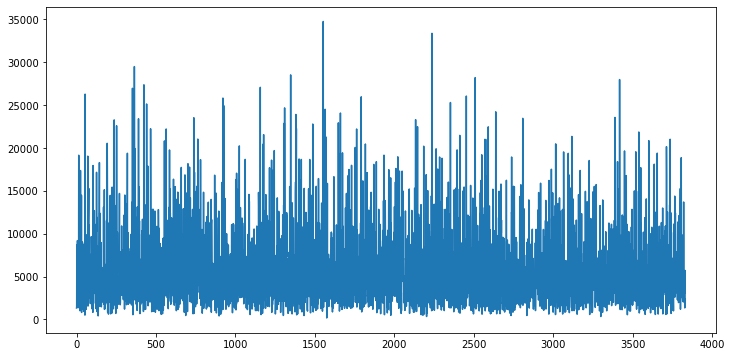

In [15]:
trades.groupby(by=["time_id"])["avg_trade_size"].agg(np.sum).reset_index(drop=True).plot()

#### Generating model ready data

In [64]:
def prepare_stock_data(stock_id, mode="train"):
    # Load book and trades data
    book = pd.read_parquet(f"{Config.data_dir}/book_{mode}.parquet/stock_id={stock_id}")
    trades = pd.read_parquet(f"{Config.data_dir}/trade_{mode}.parquet/stock_id={stock_id}")
    
    book.sort_values(by=["time_id", "seconds_in_bucket"])
    trades.sort_values(by=["time_id", "seconds_in_bucket"])
    
    book_df = gather_book_stats(book)
    
    book_df["logret"] = book_df.groupby("time_id")["wap"].apply(log_return).reset_index(drop=True).fillna(0)
    book_df["logret_l2"] = book_df.groupby("time_id")["wap_l2"].apply(log_return).reset_index(drop=True).fillna(0)
    
    # Realized volatility
    agg_book_df = pd.merge(
        book_df.groupby("time_id")["logret"].agg(realized_volatility).reset_index(),
        book_df.groupby("time_id")["logret_l2"].agg(realized_volatility).reset_index(),
        on=["time_id"]
    )
    
    agg_book_df = pd.merge(
        book_df.groupby("time_id").agg(
            {
                "l1_size_spread": ['mean', 'std'],
                "l1_price_spread": ['mean', 'std']
            }
        ).reset_index(),
        agg_book_df,
        on=["time_id"]
    )
    
    agg_book_df = pd.merge(
        gather_trade_stats(trades),
        agg_book_df,
        on=["time_id"]
    )
    
    agg_book_df["stock_id"] = stock_id
    
    def new_columns(col):
        if isinstance(col, tuple):
            return "_".join(col)
        return col
    agg_book_df.columns = map(new_columns, agg_book_df.columns)
    agg_book_df.drop(columns=['time_id_'], inplace=True)
    
    return agg_book_df   

In [65]:
df = prepare_stock_data(0, "test")

In [66]:
df.head()

,time_id,avg_trade_size,l1_size_spread_mean,l1_size_spread_std,l1_price_spread_mean,l1_price_spread_std,logret,logret_l2,stock_id
0,4,48.6190,-84,161.0807,0.0006,0.0000,0.0003,0.0003,0


In [ ]:
def ge

In [67]:
book = pd.read_parquet(f"{Config.data_dir}/book_train.parquet/stock_id=0")

In [69]:
book.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.0014,1.0023,1.0014,1.0024,3,226,2,100
1,5,1,1.0014,1.0023,1.0014,1.0024,3,100,2,100
2,5,5,1.0014,1.0023,1.0014,1.0024,3,100,2,100
3,5,6,1.0014,1.0023,1.0014,1.0024,3,126,2,100
4,5,7,1.0014,1.0023,1.0014,1.0024,3,126,2,100
